In [3]:
import pandas as pd
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.regularizers import l2
import os

%matplotlib inline
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(11) # It's my lucky number
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
import itertools

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.wrappers.scikit_learn import KerasClassifier
from keras.applications.inception_v3 import InceptionV3
from keras import backend as K 
import random
import urllib.request
import matplotlib.image as mpimg

from skimage.filters import rank, threshold_otsu
from skimage import io
from skimage.color import rgb2gray
from sklearn.cluster import KMeans
from skimage.morphology import closing, square, disk

In [4]:
# Defining the path for train and test images
data_dir = pathlib.Path("/content/drive/MyDrive/color")
train='/content/drive/MyDrive/colorr'

In [5]:
# Here we have two class.
dataset_path_train = os.listdir(data_dir)
print (dataset_path_train)
print("Types of classes labels found: ", len(dataset_path_train))

['Tomato___Tomato_mosaic_virus', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Bacterial_spot', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___healthy', 'Tomato___Target_Spot', 'Strawberry___Leaf_scorch', 'Pepper,_bell___Bacterial_spot', 'Soybean___healthy', 'Potato___healthy', 'Potato___Early_blight', 'Squash___Powdery_mildew', 'Potato___Late_blight', 'Strawberry___healthy', 'Raspberry___healthy', 'Pepper,_bell___healthy', 'Peach___healthy', 'Peach___Bacterial_spot', 'Orange___Haunglongbing_(Citrus_greening)', 'Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___healthy', 'Corn_(maize)___Northern_Leaf_Blight', 'Grape___Black_rot'

In [6]:
image_count_train = len(list(data_dir.glob('*/*.JPG')))
print("The number of Train data:",image_count_train)

The number of Train data: 50582


In [7]:
# This Parameter we can use it in the network and model
batch_size = 32
img_height = 224
img_width = 224

In [8]:
# For train data set
train_ds = image_dataset_from_directory(data_dir, 
                                        seed = 123, 
                                        image_size=(img_height, img_width), 
                                        validation_split=0.2, 
                                        subset='training')

Found 52084 files belonging to 38 classes.
Using 41668 files for training.


In [9]:
# here we can put the validate data
val_ds = image_dataset_from_directory(data_dir, 
                                      seed = 123, 
                                      image_size=(img_height, img_width), 
                                      validation_split=0.2, 
                                      subset='validation')

Found 52084 files belonging to 38 classes.
Using 10416 files for validation.


In [10]:
# here we can put the validate data
test = image_dataset_from_directory(data_dir, 
                                      seed = 123, 
                                      image_size=(img_height, img_width), 
                                      validation_split=None)

Found 52084 files belonging to 38 classes.


In [11]:
# Here We give the name of the data the we found the Benign dataset and malignant
class_names = train_ds.class_names
print(len(class_names))
print( class_names)

38
['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target

In [12]:
for image_batch, labels_batch in train_ds.take(1):
    print(image_batch.shape)
    print(labels_batch.shape)

(32, 224, 224, 3)
(32,)


In [13]:
num_classes = 38

# Building model with data augmentation and drop out layers
# Model building - Data augmentation -> Rescaling -> Conv2D -> MaxPooling2D -> Conv2D -> MaxPooling2D -> Conv2D -> MaxPooling2D -> Dropout -> Dense -> Dense
model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(Conv2D(16, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())

model.add(Conv2D(32, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())

model.add(Conv2D(64, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.15))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(num_classes))

In [14]:
# Compile the model 

## Your code goes here
model.compile(optimizer='adam',
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 activation (Activation)     (None, 224, 224, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 activation_1 (Activation)   (None, 112, 112, 32)      0         
                                                        

In [18]:
epochs = 5

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
1303/1303 [==============================] - 7092s 5s/step - loss: 0.9270 - accuracy: 0.7310 - val_loss: 0.5910 - val_accuracy: 0.8152
Epoch 2/5
1303/1303 [==============================] - 2898s 2s/step - loss: 0.3149 - accuracy: 0.8994 - val_loss: 0.3693 - val_accuracy: 0.8823
Epoch 3/5
1303/1303 [==============================] - 2913s 2s/step - loss: 0.1790 - accuracy: 0.9424 - val_loss: 0.3175 - val_accuracy: 0.9050
Epoch 4/5
1303/1303 [==============================] - 2930s 2s/step - loss: 0.1100 - accuracy: 0.9632 - val_loss: 0.4062 - val_accuracy: 0.8906
Epoch 5/5
1303/1303 [==============================] - 2953s 2s/step - loss: 0.0929 - accuracy: 0.9701 - val_loss: 0.4080 - val_accuracy: 0.8946


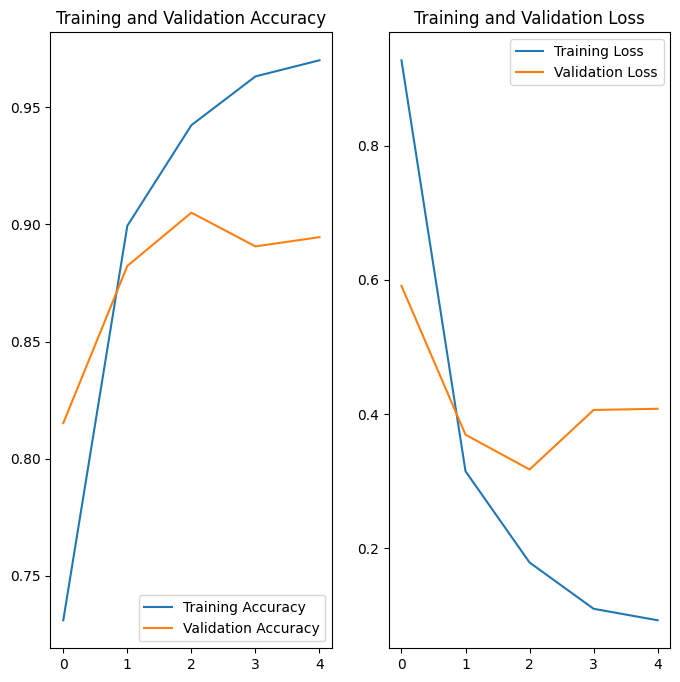

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [20]:
preformance = model.evaluate(val_ds)

326/326 [==============================] - 228s 695ms/step - loss: 0.4080 - accuracy: 0.8946


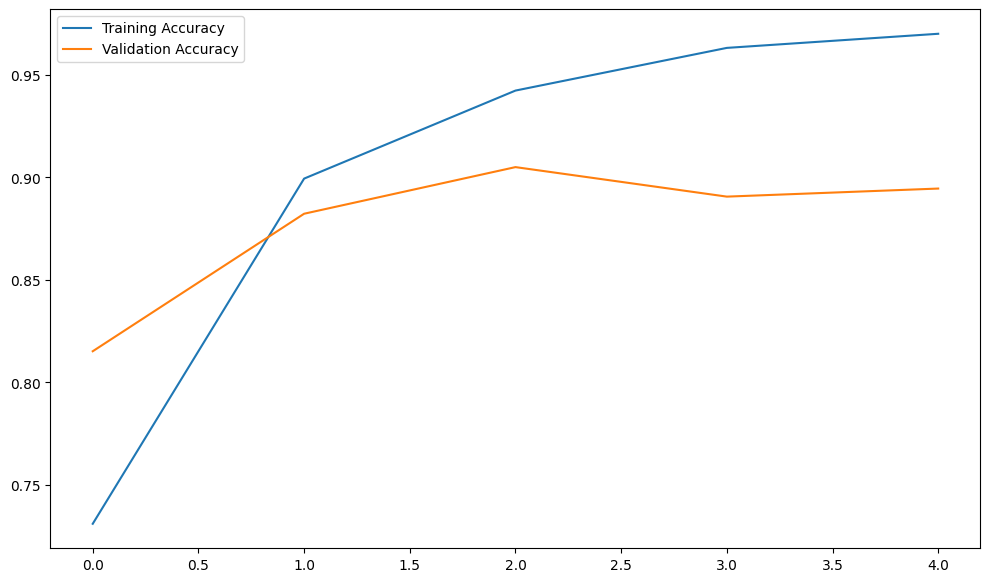

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
no_of_epochs = history.params['epochs']
len(history.history['accuracy']) == no_of_epochs
plt.figure(figsize=(12, 7))

plt.plot(range(no_of_epochs), acc, label='Training Accuracy')
plt.plot(range(no_of_epochs), val_acc, label='Validation Accuracy')

plt.legend()
plt.show()

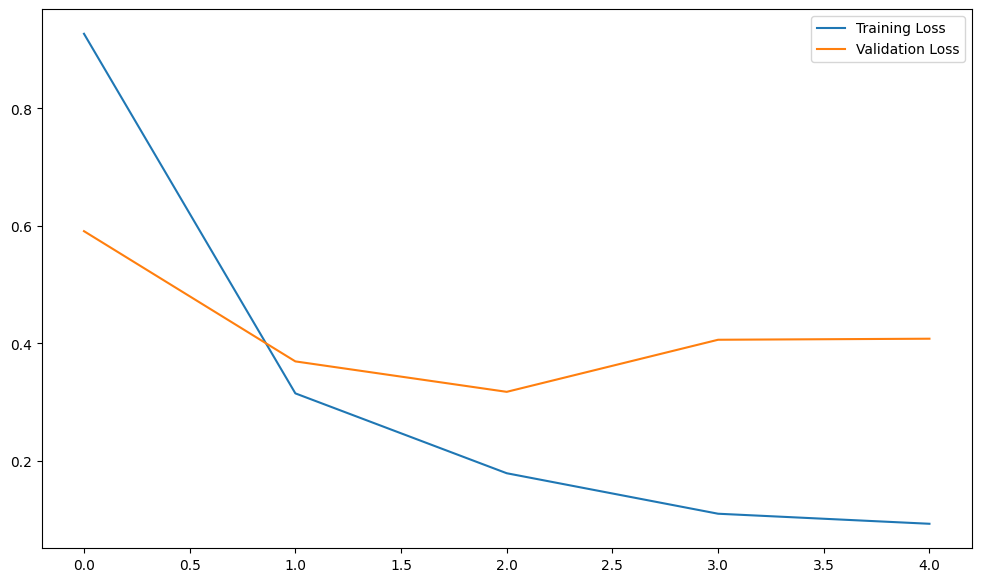

In [22]:
plt.figure(figsize=(12, 7))

plt.plot(range(no_of_epochs), loss, label='Training Loss')
plt.plot(range(no_of_epochs), val_loss, label='Validation Loss')

plt.legend()
plt.show()

actual label: Tomato___Late_blight
1/1 [==============================] - 1s 1s/step
predicted label: Tomato___Late_blight


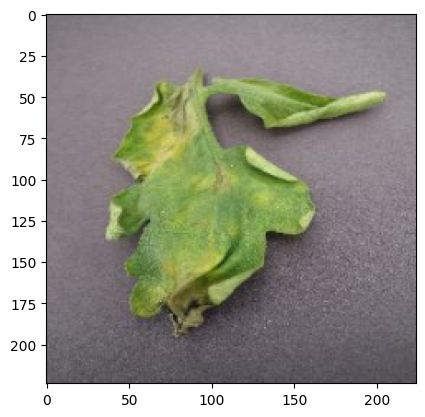

In [23]:
labels = train_ds.class_names
labels
for images_batch, labels_batch in test.take(1):
    
    image = images_batch[0].numpy().astype('uint8')
    label = labels_batch[0].numpy()
    
    plt.imshow(image)
    print("actual label:", labels[label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:", labels[np.argmax(batch_prediction[0])])

In [24]:
from tensorflow import expand_dims, newaxis

def predict(model, img):
    
    img_array = img.numpy()
    img_array = expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = labels[np.argmax(predictions[0])]
    confidence = round( (np.max(predictions[0])), 2)
    
    return predicted_class, confidence

1/1 [==============================] - 0s 70ms/step


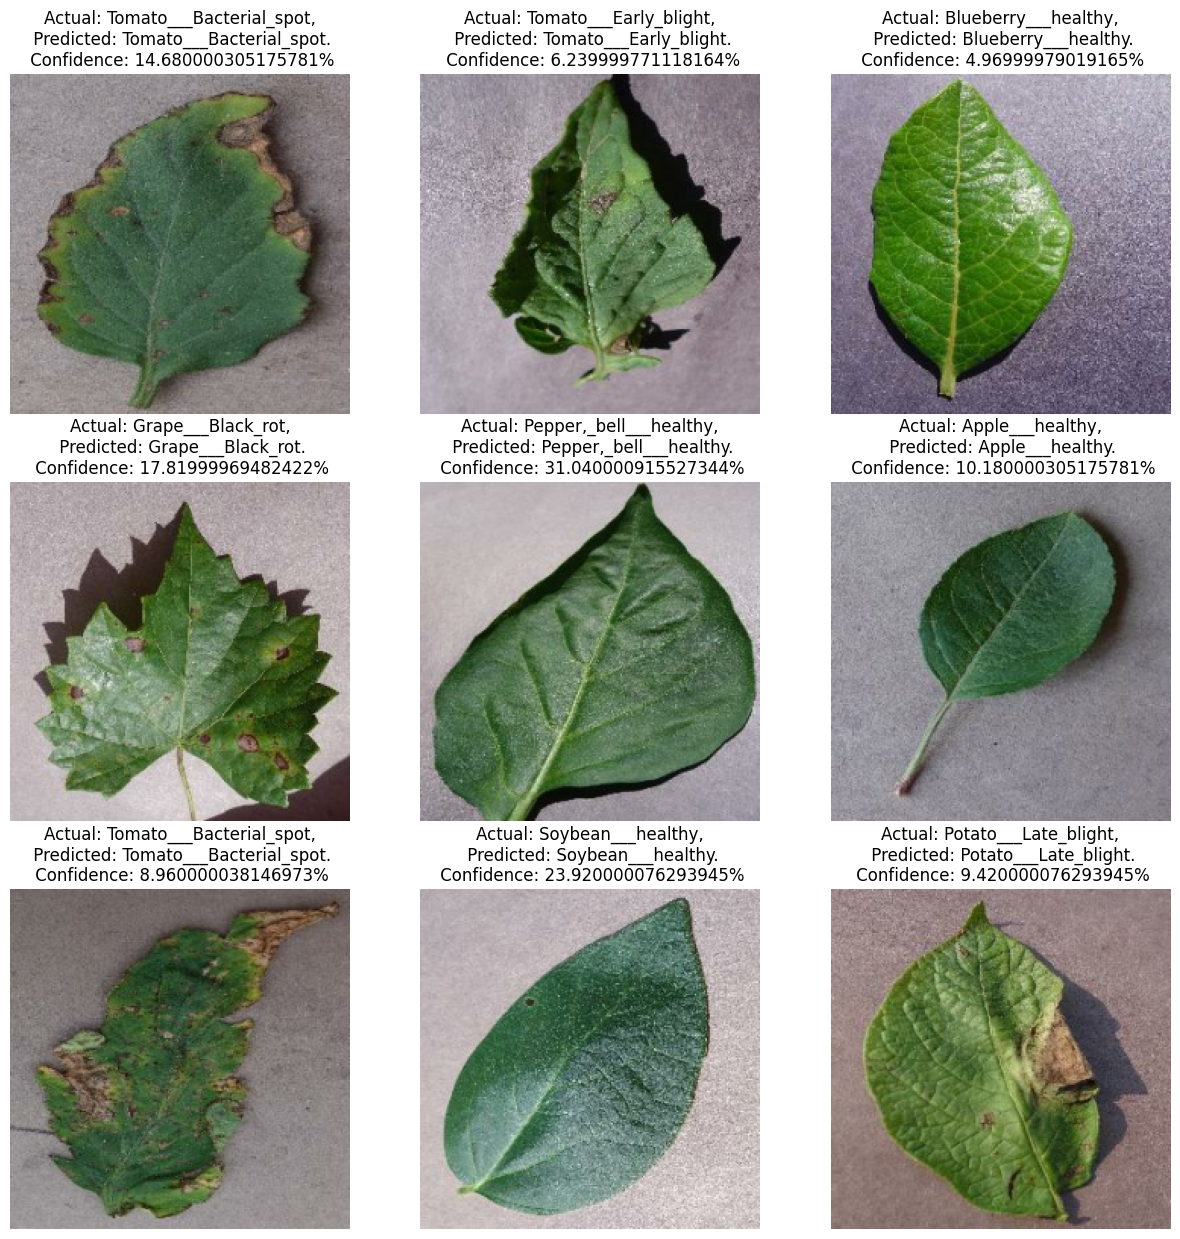

In [25]:
plt.figure(figsize=(15, 15))

for images, lbs in val_ds.take(1):
    for i in range(9):
        
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint32"))
        
        predicted_class, confidence = predict(model, images[i])
        actual_class = labels[lbs[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [26]:
model.save("Model.h5")